# BS20-RO Lev Kozlov

In [11]:
import sqlite3
from rosidl_runtime_py.utilities import get_message
from rclpy.serialization import deserialize_message
from geometry_msgs.msg import PoseStamped
from builtin_interfaces.msg import Time

import matplotlib.pyplot as plt

import numpy as np
import sympy as sp


In [12]:
class BagFileParser():
    """reference: https://answers.ros.org/question/358686/how-to-read-a-bag-file-in-ros2/"""

    def __init__(self, bag_file):
        self.conn = sqlite3.connect(bag_file)
        self.cursor = self.conn.cursor()

        # create a message type map
        topics_data = self.cursor.execute(
            "SELECT id, name, type FROM topics").fetchall()
        self.topic_type = {name_of: type_of for id_of,
                           name_of, type_of in topics_data}
        self.topic_id = {name_of: id_of for id_of,
                         name_of, type_of in topics_data}
        self.topic_msg_message = {name_of: get_message(
            type_of) for id_of, name_of, type_of in topics_data}

    def __del__(self):
        self.conn.close()

    # Return [(timestamp0, message0), (timestamp1, message1), ...]
    def get_messages(self, topic_name):

        topic_id = self.topic_id[topic_name]
        # Get from the db
        rows = self.cursor.execute(
            "SELECT timestamp, data FROM messages WHERE topic_id = {}".format(topic_id)).fetchall()
        # Deserialise all and timestamp them
        return [(timestamp, deserialize_message(data, self.topic_msg_message[topic_name])) for timestamp, data in rows]



## I set up configurations of (v, w) which I ran in the simulator

for the last configuration I converted it to (v, w) from (wl, wr) using this formula:

$$v_l = r \cdot w_l$$

$$v_r = r \cdot w_r$$

$$v = \frac{v_l + v_r}{2}$$

$$w = \frac{v_r - v_l}{L}$$

where $L$ is the distance between the wheels

In [13]:

configurations = [
    (0.5, 0.0),
    (1, 2),
    (0, 2),
    (2.66, -0.6086956521739126),
]


# As analytical solution I use this:

$$ x(t) = x_0 + \int_0^t v(t) \cos(\theta(t)) dt $$

$$ y(t) = y_0 + \int_0^t v(t) \sin(\theta(t)) dt $$

$$ \theta(t) = \theta_0 + \int_0^t w(t) dt $$

For all cases I shifted solutions to start from (0, 0, 0) as it is in the simulator.

In [14]:
def compute_analytically(config: tuple) -> sp.Function:
    """Compute the analytical solution of the trajectory"""
    v, w = config

    t = sp.symbols('t', real=True)
    
    # theta is integral of w
    theta = sp.integrate(w, t)

    # x is integral of v * cos(theta)
    x = sp.integrate(v * sp.cos(theta), t)

    # y is integral of v * sin(theta)
    y = sp.integrate(v * sp.sin(theta), t)

    print("Functions for config: v={}, w={}".format(v, w))
    sp.pprint(x)
    sp.pprint(y)
    sp.pprint(theta)

    return  sp.lambdify(t, (x, y, theta), 'numpy')


### All trajectories were saved to bag file during simulation run

In [15]:
bag_filename = lambda config_idx: f'data/hw1_config{config_idx}.bag/hw1_config{config_idx}.bag_0.db3'

def wrap_to_pi(x):
    x = np.array([x])
    xwrap = np.remainder(x, 2*np.pi)
    mask = np.abs(xwrap) > np.pi
    xwrap[mask] -= 2*np.pi * np.sign(xwrap[mask])
    return xwrap[0]

def read_pose(config_idx: int):
    parser = BagFileParser(bag_filename(config_idx))

    values = parser.get_messages("/estimated_pose")

    # actual_pose contains array of (x, y, theta)
    pose_actual = np.array([])

    timestamps = np.array([])
    for v in values:
        pose_actual = np.append(pose_actual, np.array(
            [v[1].pose.position.x, v[1].pose.position.y, v[1].pose.position.z]))

        cur_time: Time = v[1].header.stamp
        time_secs = cur_time.sec + cur_time.nanosec * 1e-9
        timestamps = np.append(timestamps, time_secs)

    timestamps = timestamps - timestamps[0]

    pose_actual = pose_actual.reshape(-1, 3)

    return timestamps, pose_actual

### As tools functions are defined we can start comparing actual and analytical trajectories for each of configurations.

In [16]:
def plot_comparison(config_idx: int, axis: int):
    axis_name = ['x', 'y', 'theta'][axis]

    timestamps, actual = read_pose(config_idx)
    sol = compute_analytically(configurations[config_idx])

    pose_analytical = np.array([
        sol(t) for t in timestamps
    ])

    # we shift to the origin because we are given that start from (0, 0, 0)
    pose_analytical[:, 0] = pose_analytical[:, 0] - pose_analytical[0, 0]
    pose_analytical[:, 1] = pose_analytical[:, 1] - pose_analytical[0, 1]
    pose_analytical[:, 2] = wrap_to_pi(pose_analytical[:, 2] - pose_analytical[0, 2])

    plt.figure()
    plt.grid(True)
    plt.title(f"Configuration {config_idx}, {axis_name}(t) for v={configurations[config_idx][0]}, w={configurations[config_idx][1]}")
    plt.plot(timestamps, actual[:, axis], label=f'{axis_name} (estimated)')
    plt.plot(timestamps, pose_analytical[:, axis], label=f'{axis_name} (analytical)')
    plt.xlabel('time, s')
    plt.ylabel(f'{axis_name}')
    plt.legend()
    plt.show()

    plt.figure()
    plt.grid(True)
    plt.title(f"Configuration {config_idx}, error {axis_name}(t) for v={configurations[config_idx][0]}, w={configurations[config_idx][1]}")
    plt.plot(timestamps, actual[:, axis] - pose_analytical[:, axis], label=f'{axis_name} (tracking error)')
    plt.xlabel('time, s')
    plt.ylabel(f'error {axis_name}')
    plt.legend()
    plt.show()

Functions for config: v=0.5, w=0.0
0.5⋅t
0
0


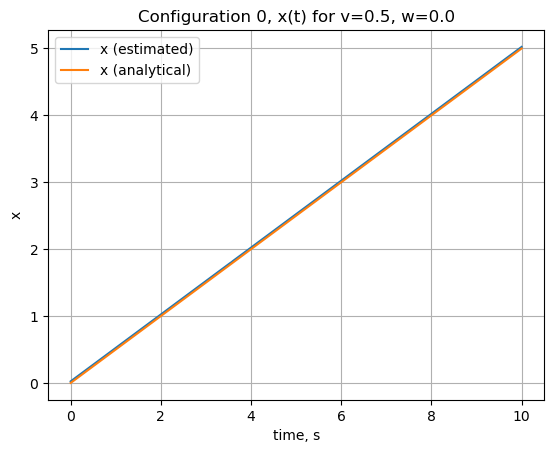

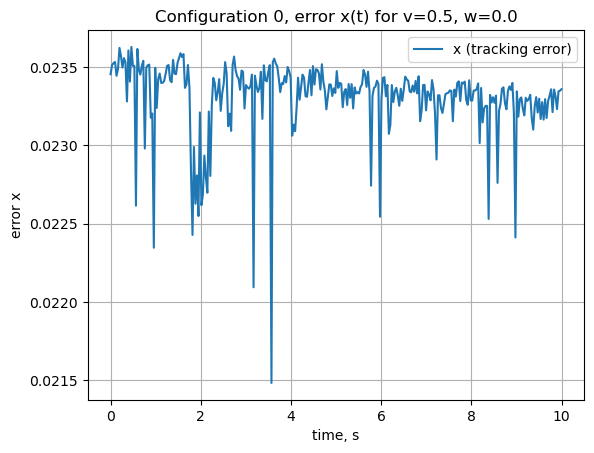

Functions for config: v=0.5, w=0.0
0.5⋅t
0
0


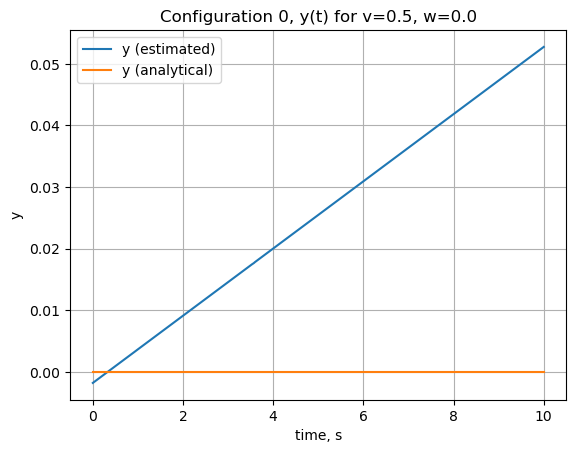

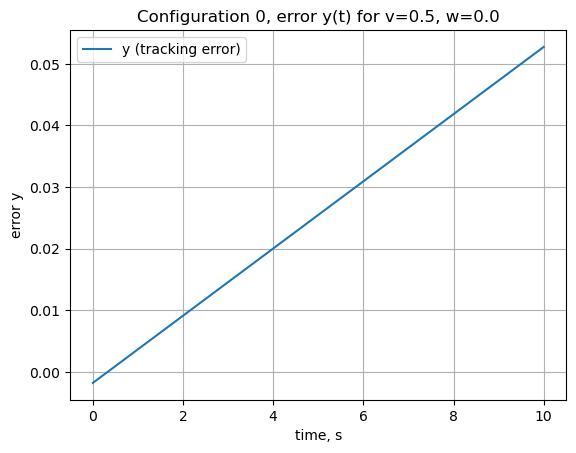

Functions for config: v=0.5, w=0.0
0.5⋅t
0
0


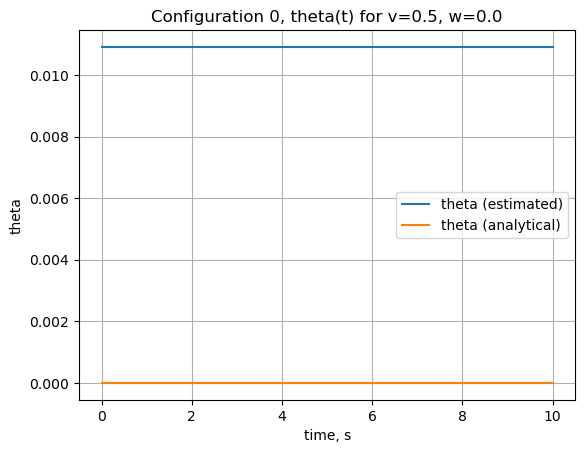

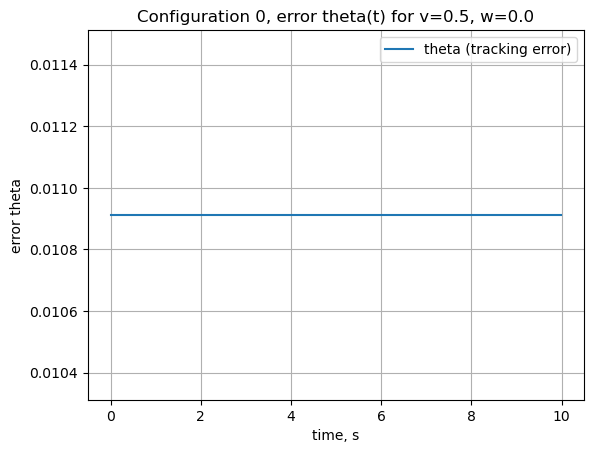

In [17]:
idx = 0

plot_comparison(idx, 0)
plot_comparison(idx, 1)
plot_comparison(idx, 2)

Functions for config: v=1, w=2
sin(2⋅t)
────────
   2    
-cos(2⋅t) 
──────────
    2     
2⋅t


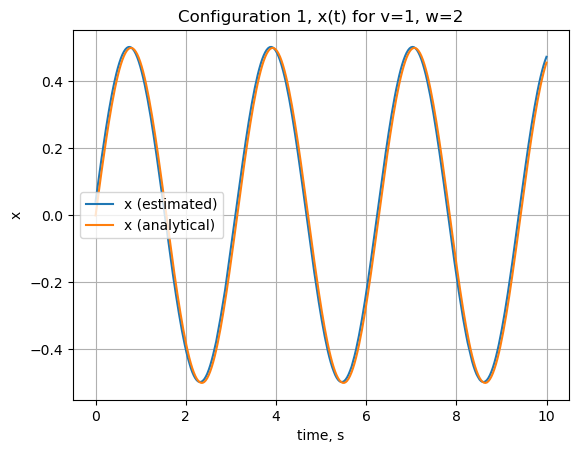

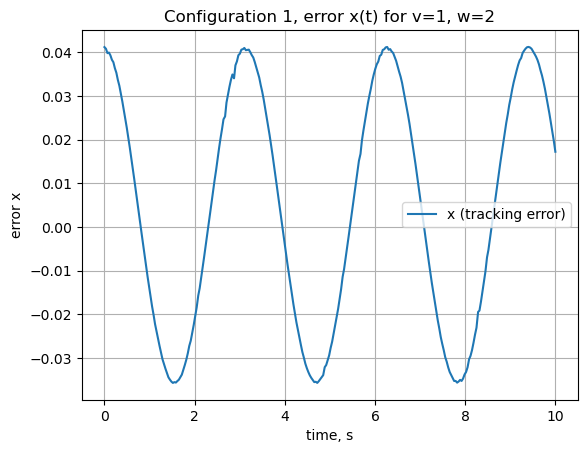

Functions for config: v=1, w=2
sin(2⋅t)
────────
   2    
-cos(2⋅t) 
──────────
    2     
2⋅t


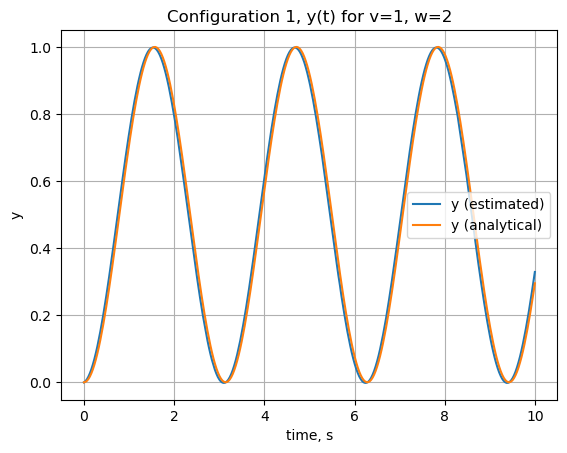

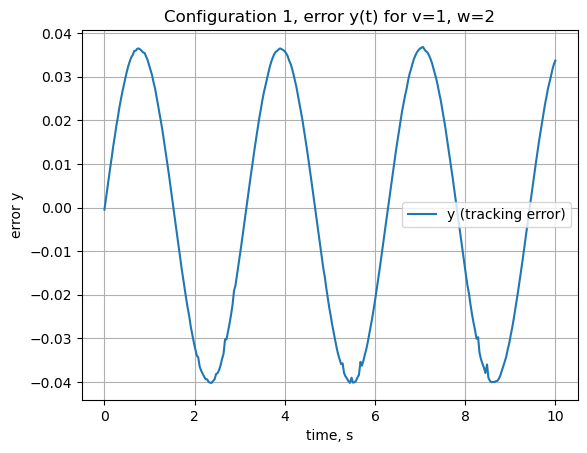

Functions for config: v=1, w=2
sin(2⋅t)
────────
   2    
-cos(2⋅t) 
──────────
    2     
2⋅t


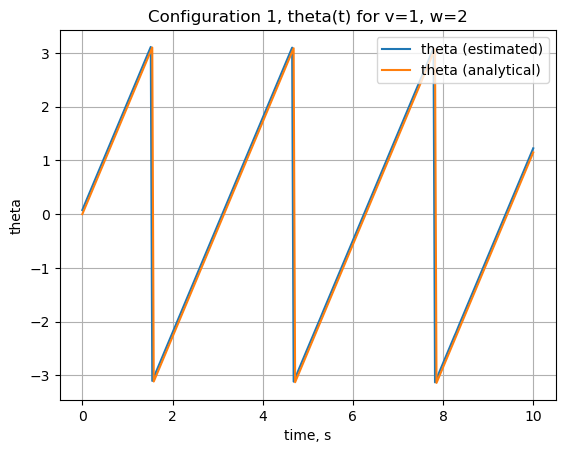

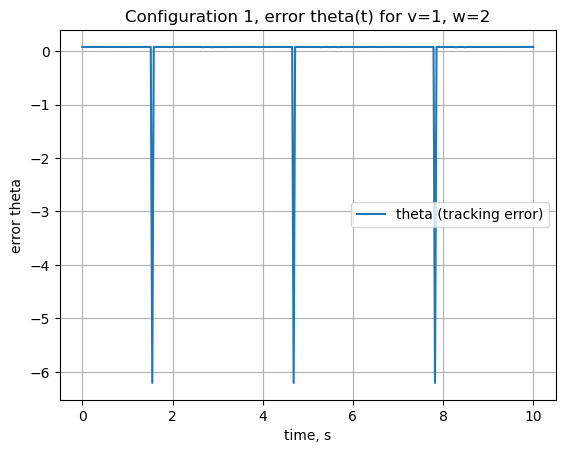

In [18]:
idx = 1

plot_comparison(idx, 0)
plot_comparison(idx, 1)
plot_comparison(idx, 2)

Functions for config: v=0, w=2
0
0
2⋅t


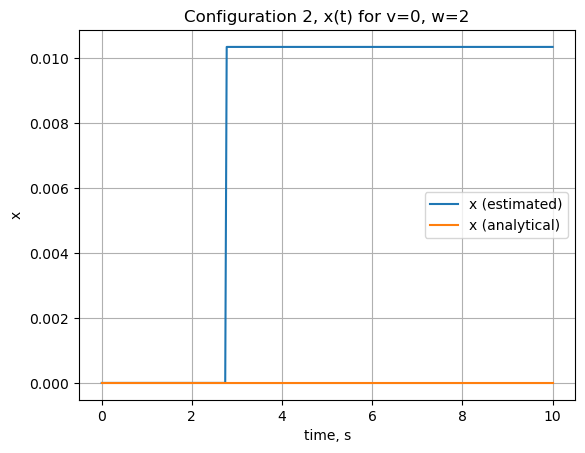

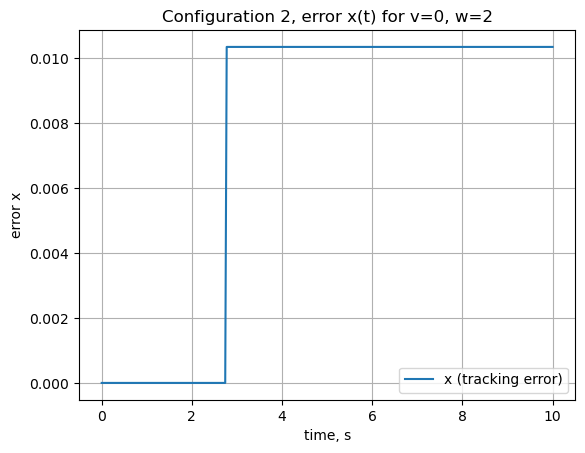

Functions for config: v=0, w=2
0
0
2⋅t


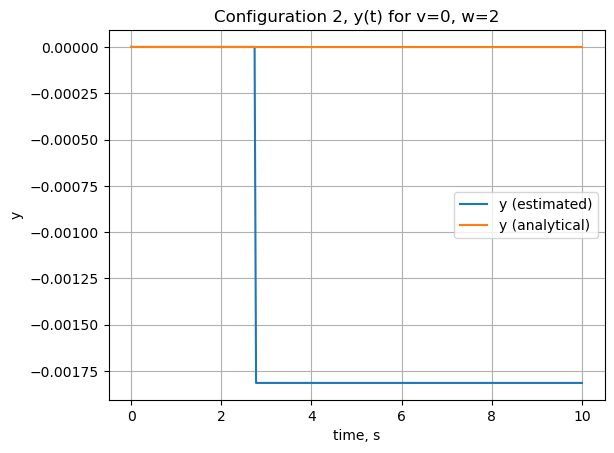

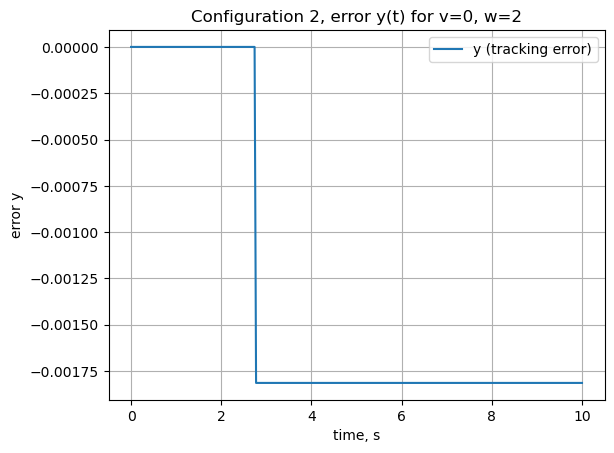

Functions for config: v=0, w=2
0
0
2⋅t


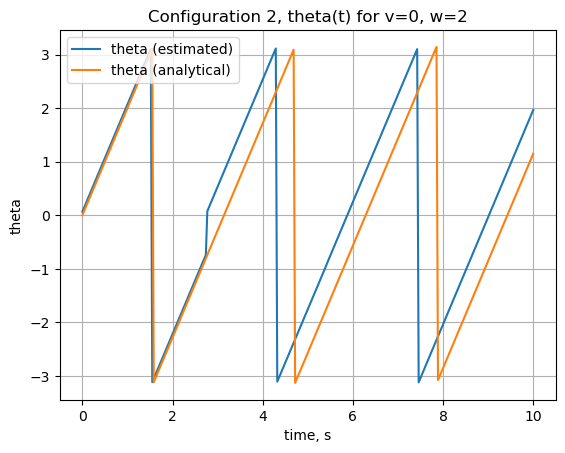

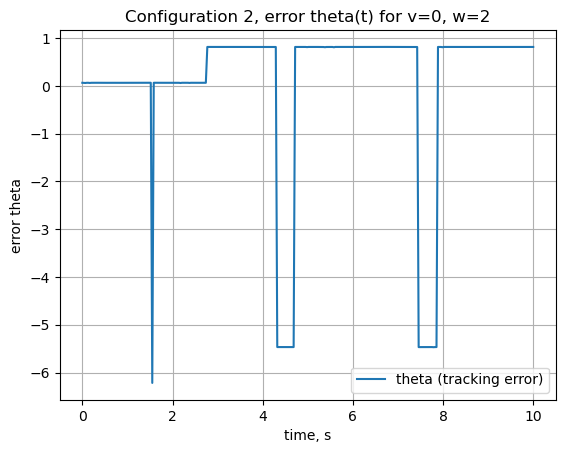

In [19]:
idx = 2

plot_comparison(idx, 0)
plot_comparison(idx, 1)
plot_comparison(idx, 2)

Functions for config: v=2.66, w=-0.6086956521739126
4.37⋅sin(0.608695652173913⋅t)
4.37⋅cos(0.608695652173913⋅t)
-0.608695652173913⋅t


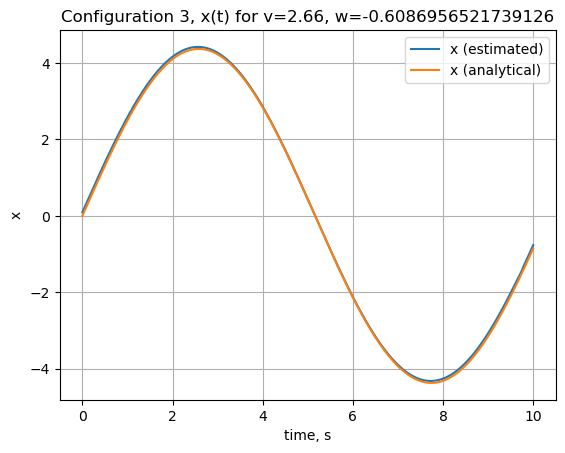

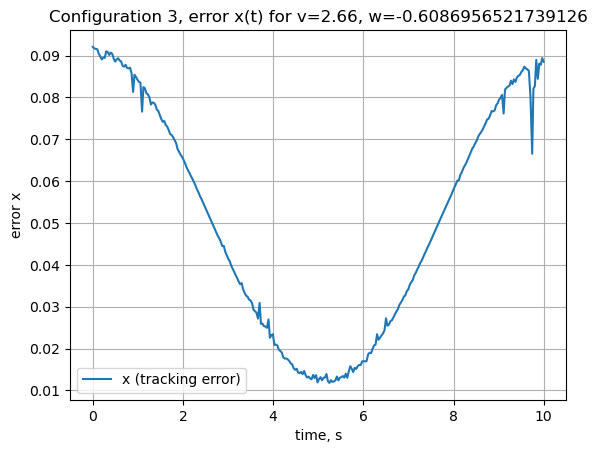

Functions for config: v=2.66, w=-0.6086956521739126
4.37⋅sin(0.608695652173913⋅t)
4.37⋅cos(0.608695652173913⋅t)
-0.608695652173913⋅t


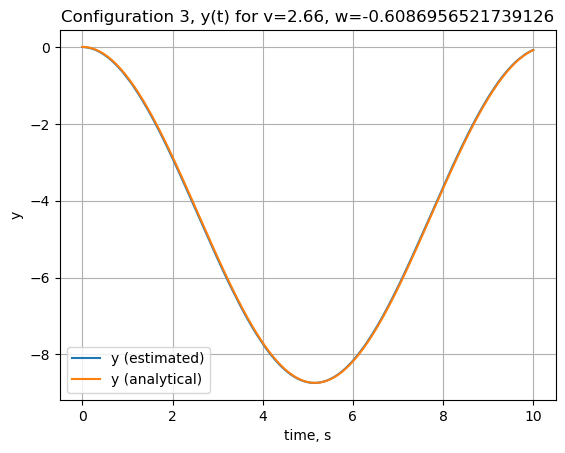

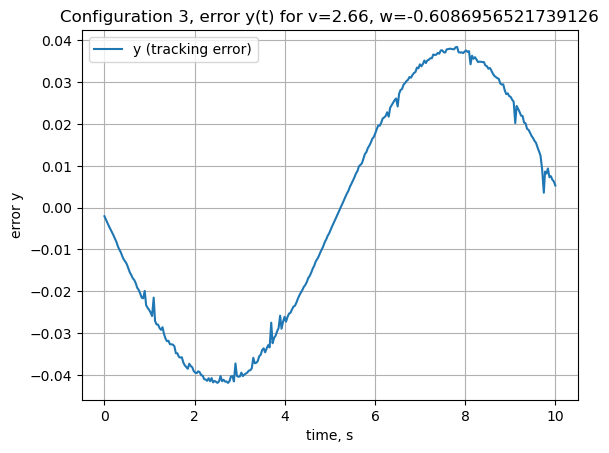

Functions for config: v=2.66, w=-0.6086956521739126
4.37⋅sin(0.608695652173913⋅t)
4.37⋅cos(0.608695652173913⋅t)
-0.608695652173913⋅t


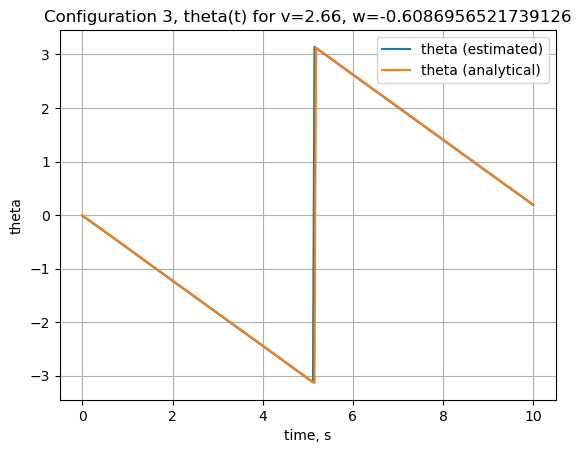

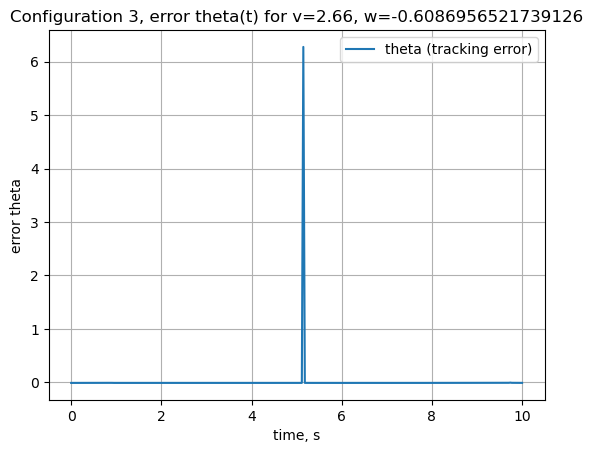

In [20]:
idx = 3

plot_comparison(idx, 0)
plot_comparison(idx, 1)
plot_comparison(idx, 2)

# Conclusion:

- As we see the error is not very big, we could say that given we used only feed-forward control it is good.
- Big jumps in theta are visible, but occur due to wrap to $\pi$. It happens due some asynchrony between analytical solution and our numerical integration.
- As another source of error we can mention that we use Euler integration technique which is not very accurate as time goes.
- With decrease of time step we could also reduce error, but it might not be an option due hardware.